# Audio Authenticity API / Scorer Quick Test Notebook

This notebook helps you sanity-check your **local scorer (the same code used by the FastAPI)** against:

- a single file
- a directory structured as:
  - `.../real/`
  - `.../fake/`

It will print example outputs, compute confusion matrices at a threshold, and show basic score distributions.

> Assumes you have `src/inference/scorer.py` with `AudioSpoofScorer` and your CNN checkpoint + (optional) calibrator.


## To do - EDA on the training and eval datasets starting with the length of the files

In [1]:
import os 
os.chdir('../')

In [2]:
# ---- Imports ----
import os
from pathlib import Path
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, roc_auc_score

# Import your scorer (same one used by the API)
from src.audio_det.inference.scorer import AudioSpoofScorer, ScorerConfig


In [ ]:
# ---- Configure paths ----
CNN_MODEL = "models/cnn/audio_cnn_balanced_best.pt"
CALIBRATOR = "models/calibrators/agg_lr_real_or_fake_new.joblib"  # set to None to disable
DEVICE = "cpu"  # or "cuda"

# Dataset directories (must have real/ and fake/ subfolders)
REAL_OR_FAKE_DIR = "data/audio/processed/real_or_fake"
ASVSPOOF21_DIR = "data/audio/processed/asvspoof_2021_df"  # e.g. "data/audio/asvspoof21_eval" (must have real/ fake/ if you want directory eval)

# Single-file test (optional)
TEST_FILE = "data/audio/processed/real_or_fake/real/file20.wav_16k.wav_norm.wav_mono.wav_silence.wav"
THRESHOLD = 0.5

print('CNN_MODEL exists:', Path(CNN_MODEL).exists())
print('CALIBRATOR exists:', Path(CALIBRATOR).exists() if CALIBRATOR else None)
print('REAL_OR_FAKE_DIR exists:', Path(REAL_OR_FAKE_DIR).exists())
print('TEST_FILE exists:', Path(TEST_FILE).exists())


CNN_MODEL exists: True
CALIBRATOR exists: True
REAL_OR_FAKE_DIR exists: True
TEST_FILE exists: True


In [20]:
cnn_override = 0.9999

In [21]:
# ---- Instantiate scorer ----
scorer = AudioSpoofScorer(
    cnn_model_path=CNN_MODEL,
    calibrator_path=CALIBRATOR if CALIBRATOR and Path(CALIBRATOR).exists() else None,
    device=DEVICE,
    config=ScorerConfig(n_segments=6, clip_seconds=4.0, cnn_agg="median", low_thr=0.3, high_thr=0.7
    ,cnn_override_thr=cnn_override
    ),
)
print("Loaded scorer. Calibrator enabled:", scorer.calibrator is not None)
print("CNN cfg sample_rate:", scorer.cfg.get("sample_rate"))


Loaded scorer. Calibrator enabled: True
CNN cfg sample_rate: 16000


In [5]:
# ---- Score a single file ----
report = scorer.score_file(TEST_FILE, threshold=THRESHOLD)
report


{'ok': True,
 'filename': 'file20.wav_16k.wav_norm.wav_mono.wav_silence.wav',
 'score': 0.745449,
 'tier': 'high',
 'decision': 'fake',
 'signals': {'cnn_only_score': 0.951475,
  'calibrated_score': 0.745449,
  'cnn_median': 0.951475,
  'cnn_max': 0.951475,
  'cnn_var': 0.0,
  'total_seconds': 1.815687,
  'silence_ratio': 0.244535},
 'segments': [0.951475, 0.951475, 0.951475, 0.951475, 0.951475, 0.951475],
 'meta': {'sr': 16000,
  'clip_seconds': 4.0,
  'n_segments': 6,
  'cnn_agg': 'median'},
 'model': {'cnn_model': 'SmallResNet', 'calibrator': True}}

In [22]:
# ---- Helper: score a dataset directory ----
AUDIO_EXTS = {".wav", ".flac", ".mp3", ".ogg", ".m4a"}  # torchaudio support varies by build

def list_audio_files(root: Path):
    return sorted([p for p in root.rglob("*") if p.is_file() and p.suffix.lower() in AUDIO_EXTS])

import random

def score_dataset_dir(
    base_dir: str,
    threshold: float = 0.5,
    max_per_class: int = 1000,
    seed: int | None = 42,
):
    base = Path(base_dir)
    real_dir = base / "real"
    fake_dir = base / "fake"
    assert real_dir.is_dir() and fake_dir.is_dir(), f"Expected {real_dir} and {fake_dir}"

    rng = random.Random(seed)

    def sample_files(dir_path: Path):
        files = list_audio_files(dir_path)
        if max_per_class is not None and len(files) > max_per_class:
            files = rng.sample(files, max_per_class)
        return sorted(files)

    rows = []

    for label_name, y_true in [("real", 0), ("fake", 1)]:
        files = sample_files(base / label_name)

        print(f"{label_name}: scoring {len(files)} files")

        for f in files:
            rep = scorer.score_file(str(f), threshold=threshold)

            if not rep.get("ok", False):
                rows.append({
                    "path": str(f),
                    "y_true": y_true,
                    "ok": False,
                    "error": rep.get("error"),
                })
                continue

            rows.append({
                "path": str(f),
                "y_true": y_true,
                "ok": True,
                "score": rep["score"],
                "tier": rep["tier"],
                "decision": rep["decision"],
                "cnn_only_score": rep["signals"]["cnn_only_score"],
                "calibrated_score": rep["signals"]["calibrated_score"],
                "cnn_median": rep["signals"]["cnn_median"],
                "cnn_max": rep["signals"]["cnn_max"],
                "cnn_var": rep["signals"]["cnn_var"],
                "silence_ratio": rep["signals"]["silence_ratio"],
                "total_seconds": rep["signals"]["total_seconds"],
            })

    return pd.DataFrame(rows)


def summarize_df(df: pd.DataFrame, score_col: str = "score", threshold: float = 0.5):
    d = df[df["ok"]].copy()
    y_true = d["y_true"].to_numpy()
    probs = d[score_col].to_numpy(dtype=float)
    y_pred = (probs >= threshold).astype(int)

    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    auc = roc_auc_score(y_true, probs) if len(np.unique(y_true)) > 1 else np.nan

    real_acc = (y_pred[y_true==0] == 0).mean() if (y_true==0).any() else np.nan
    fake_acc = (y_pred[y_true==1] == 1).mean() if (y_true==1).any() else np.nan
    overall_acc = (y_pred == y_true).mean() if len(y_true) else np.nan

    tp = int(((y_pred==1) & (y_true==1)).sum())
    fp = int(((y_pred==1) & (y_true==0)).sum())
    precision = tp / (tp + fp) if (tp + fp) else 0.0

    return {
        "n_ok": int(len(d)),
        "auc": float(auc) if not np.isnan(auc) else None,
        "real_accuracy": float(real_acc) if not np.isnan(real_acc) else None,
        "fake_accuracy": float(fake_acc) if not np.isnan(fake_acc) else None,
        "overall_accuracy": float(overall_acc) if not np.isnan(overall_acc) else None,
        "precision": float(precision),
        "confusion_matrix": cm.tolist(),
        "labels": ["real","fake"],
    }


In [23]:
# ---- Score REAL_OR_FAKE dataset ----
df_rof = score_dataset_dir(
    REAL_OR_FAKE_DIR,
    threshold=0.5,
    max_per_class=1000,
    seed=42,
)

df_rof.head()


real: scoring 1000 files
fake: scoring 1000 files


,path,y_true,ok,score,tier,decision,cnn_only_score,calibrated_score,cnn_median,cnn_max,cnn_var,silence_ratio,total_seconds
0,data/audio/processed/real_or_fake/real/file1.w...,0,True,0.035280,low,real,0.002384,0.035280,0.002384,0.002384,0.0,0.245387,2.472375
1,data/audio/processed/real_or_fake/real/file100...,0,True,0.955692,high,fake,0.987509,0.955692,0.987509,0.987509,0.0,0.168872,0.944875
2,data/audio/processed/real_or_fake/real/file100...,0,True,0.282022,low,real,0.474292,0.282022,0.474292,0.474292,0.0,0.240153,2.007312
3,data/audio/processed/real_or_fake/real/file100...,0,True,0.032991,low,real,0.325807,0.032991,0.325807,0.325807,0.0,0.368410,2.090063
4,data/audio/processed/real_or_fake/real/file100...,0,True,0.019317,low,real,0.025370,0.019317,0.025370,0.025370,0.0,0.239890,3.322875


In [6]:
# ---- Score REAL_OR_FAKE dataset ----
df_rof = score_dataset_dir(
    REAL_OR_FAKE_DIR,
    threshold=0.5,
    max_per_class=1000,
    seed=42,
)

df_rof.head()


real: scoring 1000 files
fake: scoring 1000 files


,path,y_true,ok,score,tier,decision,cnn_only_score,calibrated_score,cnn_median,cnn_max,cnn_var,silence_ratio,total_seconds
0,data/audio/processed/real_or_fake/real/file1.w...,0,True,0.035280,low,real,0.002384,0.035280,0.002384,0.002384,0.0,0.245387,2.472375
1,data/audio/processed/real_or_fake/real/file100...,0,True,0.987509,high,fake,0.987509,0.955692,0.987509,0.987509,0.0,0.168872,0.944875
2,data/audio/processed/real_or_fake/real/file100...,0,True,0.282022,low,real,0.474292,0.282022,0.474292,0.474292,0.0,0.240153,2.007312
3,data/audio/processed/real_or_fake/real/file100...,0,True,0.032991,low,real,0.325807,0.032991,0.325807,0.325807,0.0,0.368410,2.090063
4,data/audio/processed/real_or_fake/real/file100...,0,True,0.019317,low,real,0.025370,0.019317,0.025370,0.025370,0.0,0.239890,3.322875


In [7]:
THRESHOLD = 0.5

In [12]:
# ---- Summary (final score) ----
summary_final = summarize_df(df_rof, score_col="score", threshold=THRESHOLD)
summary_final


{'n_ok': 2000,
 'auc': 0.8946750000000001,
 'real_accuracy': 0.779,
 'fake_accuracy': 0.856,
 'overall_accuracy': 0.8175,
 'precision': 0.7948003714020427,
 'confusion_matrix': [[779, 221], [144, 856]],
 'labels': ['real', 'fake']}

In [24]:
# cnn_override multicheck logic (0.9999)
# ---- Summary (final score) ----
summary_final = summarize_df(df_rof, score_col="score", threshold=THRESHOLD)
summary_final

{'n_ok': 2000,
 'auc': 0.8885299999999998,
 'real_accuracy': 0.76,
 'fake_accuracy': 0.857,
 'overall_accuracy': 0.8085,
 'precision': 0.7812215132178669,
 'confusion_matrix': [[760, 240], [143, 857]],
 'labels': ['real', 'fake']}

In [19]:
# cnn_override multicheck logic (0.99)
# ---- Summary (final score) ----
summary_final = summarize_df(df_rof, score_col="score", threshold=THRESHOLD)
summary_final

{'n_ok': 2000,
 'auc': 0.8639540000000001,
 'real_accuracy': 0.728,
 'fake_accuracy': 0.872,
 'overall_accuracy': 0.8,
 'precision': 0.7622377622377622,
 'confusion_matrix': [[728, 272], [128, 872]],
 'labels': ['real', 'fake']}

In [14]:
# cnn_override multicheck logic (0.98)
# ---- Summary (final score) ----
summary_final = summarize_df(df_rof, score_col="score", threshold=THRESHOLD)
summary_final

{'n_ok': 2000,
 'auc': 0.8551030000000001,
 'real_accuracy': 0.718,
 'fake_accuracy': 0.877,
 'overall_accuracy': 0.7975,
 'precision': 0.7566867989646247,
 'confusion_matrix': [[718, 282], [123, 877]],
 'labels': ['real', 'fake']}

In [9]:
# cnn_override multicheck logic (0.95)
# ---- Summary (final score) ----
summary_final = summarize_df(df_rof, score_col="score", threshold=THRESHOLD)
summary_final

{'n_ok': 2000,
 'auc': 0.8551030000000001,
 'real_accuracy': 0.718,
 'fake_accuracy': 0.877,
 'overall_accuracy': 0.7975,
 'precision': 0.7566867989646247,
 'confusion_matrix': [[718, 282], [123, 877]],
 'labels': ['real', 'fake']}

In [10]:
# cnn_override multicheck logic (0.98)
# ---- Summary (final score) ----
summary_final = summarize_df(df_rof, score_col="score", threshold=THRESHOLD)
summary_final

{'n_ok': 2000,
 'auc': 0.8551030000000001,
 'real_accuracy': 0.718,
 'fake_accuracy': 0.877,
 'overall_accuracy': 0.7975,
 'precision': 0.7566867989646247,
 'confusion_matrix': [[718, 282], [123, 877]],
 'labels': ['real', 'fake']}

In [ ]:
# cnn_override = .95
# ---- Summary (final score) ----
summary_final = summarize_df(df_rof, score_col="score", threshold=THRESHOLD)
summary_final

{'n_ok': 2000,
 'auc': 0.8437879999999999,
 'real_accuracy': 0.693,
 'fake_accuracy': 0.888,
 'overall_accuracy': 0.7905,
 'precision': 0.7430962343096235,
 'confusion_matrix': [[693, 307], [112, 888]],
 'labels': ['real', 'fake']}

In [14]:
# cnn_override = .98
# ---- Summary (final score) ----
summary_final = summarize_df(df_rof, score_col="score", threshold=THRESHOLD)
summary_final

{'n_ok': 2000,
 'auc': 0.8551030000000001,
 'real_accuracy': 0.718,
 'fake_accuracy': 0.877,
 'overall_accuracy': 0.7975,
 'precision': 0.7566867989646247,
 'confusion_matrix': [[718, 282], [123, 877]],
 'labels': ['real', 'fake']}

In [18]:
# cnn_override = .99999999
# ---- Summary (final score) ----
summary_final = summarize_df(df_rof, score_col="score", threshold=THRESHOLD)
summary_final

{'n_ok': 2000,
 'auc': 0.8888935,
 'real_accuracy': 0.76,
 'fake_accuracy': 0.856,
 'overall_accuracy': 0.808,
 'precision': 0.781021897810219,
 'confusion_matrix': [[760, 240], [144, 856]],
 'labels': ['real', 'fake']}

In [25]:
# ---- Score REAL_OR_FAKE dataset ----
df_rof2 = score_dataset_dir(
    REAL_OR_FAKE_DIR,
    threshold=THRESHOLD,
    max_per_class=1000,
    seed=42,
)

df_rof2.head()


real: scoring 1000 files
fake: scoring 1000 files


,path,y_true,ok,score,tier,decision,cnn_only_score,calibrated_score,cnn_median,cnn_max,cnn_var,silence_ratio,total_seconds
0,data/audio/processed/real_or_fake/real/file1.w...,0,True,0.035280,low,real,0.002384,0.035280,0.002384,0.002384,0.0,0.245387,2.472375
1,data/audio/processed/real_or_fake/real/file100...,0,True,0.955692,high,fake,0.987509,0.955692,0.987509,0.987509,0.0,0.168872,0.944875
2,data/audio/processed/real_or_fake/real/file100...,0,True,0.282022,low,real,0.474292,0.282022,0.474292,0.474292,0.0,0.240153,2.007312
3,data/audio/processed/real_or_fake/real/file100...,0,True,0.032991,low,real,0.325807,0.032991,0.325807,0.325807,0.0,0.368410,2.090063
4,data/audio/processed/real_or_fake/real/file100...,0,True,0.019317,low,real,0.025370,0.019317,0.025370,0.025370,0.0,0.239890,3.322875


In [34]:
summary_cnn = summarize_df(df_rof2[df_rof2["total_seconds"]>2], score_col="score", threshold=0.6)
summary_cnn

{'n_ok': 962,
 'auc': 0.8473277231655248,
 'real_accuracy': 0.9410187667560321,
 'fake_accuracy': 0.37037037037037035,
 'overall_accuracy': 0.8128898128898129,
 'precision': 0.6451612903225806,
 'confusion_matrix': [[702, 44], [136, 80]],
 'labels': ['real', 'fake']}

In [ ]:
summary_cnn = summarize_df(df_rof2[df_rof2["total_seconds"]>1], score_col="score", threshold=0.6)
summary_cnn

{'n_ok': 2000,
 'auc': 0.8946750000000001,
 'real_accuracy': 0.836,
 'fake_accuracy': 0.801,
 'overall_accuracy': 0.8185,
 'precision': 0.8300518134715026,
 'confusion_matrix': [[836, 164], [199, 801]],
 'labels': ['real', 'fake']}

In [24]:
summary_cnn = summarize_df(df_rof, score_col="score", threshold=THRESHOLD)
summary_cnn

{'n_ok': 2000,
 'auc': 0.8946750000000001,
 'real_accuracy': 0.937,
 'fake_accuracy': 0.533,
 'overall_accuracy': 0.735,
 'precision': 0.8942953020134228,
 'confusion_matrix': [[937, 63], [467, 533]],
 'labels': ['real', 'fake']}

In [23]:
# ---- Summary (CNN-only score) ----
summary_cnn = summarize_df(df_rof, score_col="cnn_only_score", threshold=THRESHOLD)
summary_cnn


{'n_ok': 2000,
 'auc': 0.8348829999999999,
 'real_accuracy': 0.656,
 'fake_accuracy': 0.84,
 'overall_accuracy': 0.748,
 'precision': 0.7094594594594594,
 'confusion_matrix': [[656, 344], [160, 840]],
 'labels': ['real', 'fake']}

In [14]:
# ---- Investigate constant segment scores (like your API output) ----
# If segments are identical for many files, this will show it quickly.
# (Often indicates audio shorter than clip_seconds and being heavily padded, or model saturation.)
d = df_rof[df_rof["ok"]].copy()
print("Total ok:", len(d))
print("Duration seconds - min/median/max:", d["total_seconds"].min(), d["total_seconds"].median(), d["total_seconds"].max())
print("cnn_var - min/median/max:", d["cnn_var"].min(), d["cnn_var"].median(), d["cnn_var"].max())

# How many have (near) zero variance?
print("Fraction with cnn_var < 1e-6:", float((d["cnn_var"] < 1e-6).mean()))


Total ok: 2000
Duration seconds - min/median/max: 0.403438 1.946781 5.420687
cnn_var - min/median/max: 0.0 0.0 0.063682
Fraction with cnn_var < 1e-6: 0.988


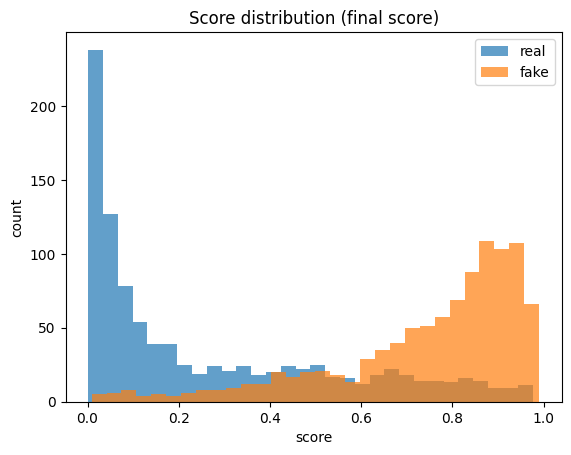

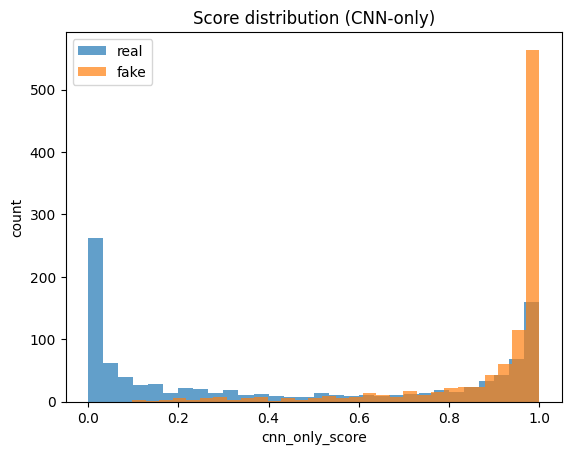

In [15]:
# ---- Score distributions (histograms) ----
d = df_rof[df_rof["ok"]].copy()

plt.figure()
plt.hist(d[d["y_true"]==0]["score"].values, bins=30, alpha=0.7, label="real")
plt.hist(d[d["y_true"]==1]["score"].values, bins=30, alpha=0.7, label="fake")
plt.title("Score distribution (final score)")
plt.xlabel("score")
plt.ylabel("count")
plt.legend()
plt.show()

plt.figure()
plt.hist(d[d["y_true"]==0]["cnn_only_score"].values, bins=30, alpha=0.7, label="real")
plt.hist(d[d["y_true"]==1]["cnn_only_score"].values, bins=30, alpha=0.7, label="fake")
plt.title("Score distribution (CNN-only)")
plt.xlabel("cnn_only_score")
plt.ylabel("count")
plt.legend()
plt.show()


In [18]:
ASVSPOOF21_DIR = 'data/audio/processed/asvspoof_2021_df'

In [19]:
# ---- Optional: score ASVspoof directory (if structured as real/ fake/) ----
if ASVSPOOF21_DIR:
    df_asv = score_dataset_dir(ASVSPOOF21_DIR, threshold=THRESHOLD)
    print("ASV ok:", df_asv["ok"].sum(), "of", len(df_asv))
    print("Final score summary:", summarize_df(df_asv, score_col="score", threshold=THRESHOLD))
    print("CNN-only summary:", summarize_df(df_asv, score_col="cnn_only_score", threshold=THRESHOLD))
else:
    print("ASVSPOOF21_DIR is None. Set it above to run.")


real: scoring 1000 files
fake: scoring 1000 files
ASV ok: 2000 of 2000
Final score summary: {'n_ok': 2000, 'auc': 0.80662, 'real_accuracy': 0.918, 'fake_accuracy': 0.083, 'overall_accuracy': 0.5005, 'precision': 0.503030303030303, 'confusion_matrix': [[918, 82], [917, 83]], 'labels': ['real', 'fake']}
CNN-only summary: {'n_ok': 2000, 'auc': 0.9176315, 'real_accuracy': 0.726, 'fake_accuracy': 0.925, 'overall_accuracy': 0.8255, 'precision': 0.7714762301918265, 'confusion_matrix': [[726, 274], [75, 925]], 'labels': ['real', 'fake']}


## Analysis into incorrect predictions

In [36]:
df_ok = df_rof[df_rof["ok"]].copy()

# Ground truth: y_true (0=real, 1=fake)
# Prediction at your chosen operating point (e.g. 0.8)
thr = 0.8
df_ok["y_pred"] = (df_ok["score"] >= thr).astype(int)

false_positives = df_ok[(df_ok["y_true"] == 0) & (df_ok["y_pred"] == 1)]
false_negatives = df_ok[(df_ok["y_true"] == 1) & (df_ok["y_pred"] == 0)]


In [37]:
len(false_positives), len(false_negatives)

(63, 467)

In [39]:
false_positives["total_seconds"].describe()


count    63.000000
mean      1.370955
std       0.421662
min       0.737875
25%       1.122375
50%       1.248625
75%       1.537656
max       2.928062
Name: total_seconds, dtype: float64

In [40]:
false_negatives["total_seconds"].describe()

count    467.000000
mean       2.028153
std        0.625521
min        0.820937
25%        1.611156
50%        1.914125
75%        2.350750
max        5.420687
Name: total_seconds, dtype: float64

In [41]:
df_ok["total_seconds"].describe()

count    2000.000000
mean        2.068666
std         0.814141
min         0.403438
25%         1.423797
50%         1.946781
75%         2.624078
max         5.420687
Name: total_seconds, dtype: float64

In [26]:
# --- Get durations (seconds) for a list of audio files ---
from pathlib import Path
import torchaudio
import pandas as pd

def get_audio_duration_seconds(path: str) -> float:
    """
    Returns audio duration in seconds using torchaudio metadata when possible,
    otherwise falls back to loading the waveform.
    """
    try:
        info = torchaudio.info(path)
        if info.num_frames is not None and info.sample_rate is not None and info.sample_rate > 0:
            return float(info.num_frames / info.sample_rate)
    except Exception:
        pass

    # Fallback: load audio (slower)
    wav, sr = torchaudio.load(path)
    return float(wav.shape[-1] / sr) if sr else float("nan")


# --- Choose your file list ---
# Option 1: list of paths you already have
# files = your_list_of_paths

# Option 2: glob a directory (edit pattern as needed)
audio_dir = Path("/Users/stevencarrell/Desktop/dev/authenticity-risk-engine/data/audio/processed/asvspoof_2021_df/fake")  # <-- change this
files = sorted([str(p) for p in audio_dir.rglob("*.flac")])  # or "*.wav"

print(f"Found {len(files)} audio files")

rows = []
for p in files:
    dur = get_audio_duration_seconds(p)
    rows.append({"path": p, "filename": Path(p).name, "seconds": dur})

df_durations = pd.DataFrame(rows).sort_values("seconds").reset_index(drop=True)

display(df_durations.head(20))
display(df_durations.tail(20))

print(df_durations["seconds"].describe(percentiles=[0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]))


Found 147420 audio files


RuntimeError: Failed to decode audio samples: Could not receive frame from decoder: Invalid data found when processing input

In [ ]:
# --- Get durations (seconds) for a list of audio files ---
from pathlib import Path
import torchaudio
import pandas as pd

def get_audio_duration_seconds(path: str) -> float:
    """
    Returns audio duration in seconds using torchaudio metadata when possible,
    otherwise falls back to loading the waveform.
    """
    try:
        info = torchaudio.info(path)
        if info.num_frames is not None and info.sample_rate is not None and info.sample_rate > 0:
            return float(info.num_frames / info.sample_rate)
    except Exception:
        pass

    # Fallback: load audio (slower)
    wav, sr = torchaudio.load(path)
    return float(wav.shape[-1] / sr) if sr else float("nan")


# --- Choose your file list ---
# Option 1: list of paths you already have
# files = your_list_of_paths

# Option 2: glob a directory (edit pattern as needed)
audio_dir = Path("/Users/stevencarrell/Desktop/dev/authenticity-risk-engine/data/audio/processed/asvspoof_2021_df/fake")  # <-- change this
files = sorted([str(p) for p in audio_dir.rglob("*.flac")])  # or "*.wav"

print(f"Found {len(files)} audio files")

rows = []
for p in files:
    dur = get_audio_duration_seconds(p)
    rows.append({"path": p, "filename": Path(p).name, "seconds": dur})

df_durations = pd.DataFrame(rows).sort_values("seconds").reset_index(drop=True)

display(df_durations.head(20))
display(df_durations.tail(20))

print(df_durations["seconds"].describe(percentiles=[0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]))


## Notes / Debug Tips

If you see patterns like:
- **all segments identical** (cnn_var ≈ 0)
- **everything predicted fake** or **everything predicted real**

Common causes:
- many files shorter than `clip_seconds` → heavy padding + identical segment windows
- mismatch between training and inference transforms (cfg must match checkpoint)
- label direction inversion (interpreting `sigmoid(logit)` as P(fake) when it is P(real))
- calibrator applied out-of-domain (try disabling calibrator and re-check)

This notebook prints duration statistics and shows distributions so you can spot these quickly.
